# STROKE PREDICTION 
***According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for **approximately 11%** of total deaths.***

**This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.**


Throughout this notebook, we will explore the dataset, perform exploratory data analysis (EDA) to gain insights into the underlying patterns, preprocess the data to address missing values and outliers, engineer relevant features, and finally, train and evaluate various machine learning models for stroke prediction. Additionally, we will assess model performance metrics and discuss the implications of our findings.

## Load the required Libraries

In [106]:
# Load required Libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pickle


## Load and Read Dataset

In [2]:
# Load & Read Dataset
df= pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df = df.drop(columns='id',axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **EDA**

In [5]:
features = df.columns
features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
Numerical_columns = [feature for feature in features if df[feature].dtypes !='O']
Categorical_columns = [feature for feature in features if df[feature].dtypes =='O']


In [7]:

corr = df[Numerical_columns].corr().round(2)
corr


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.17,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.18,0.13
bmi,0.33,0.17,0.04,0.18,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


In [8]:
corr["stroke"].sort_values(ascending=False)

stroke               1.00
age                  0.25
hypertension         0.13
heart_disease        0.13
avg_glucose_level    0.13
bmi                  0.04
Name: stroke, dtype: float64

<Axes: >

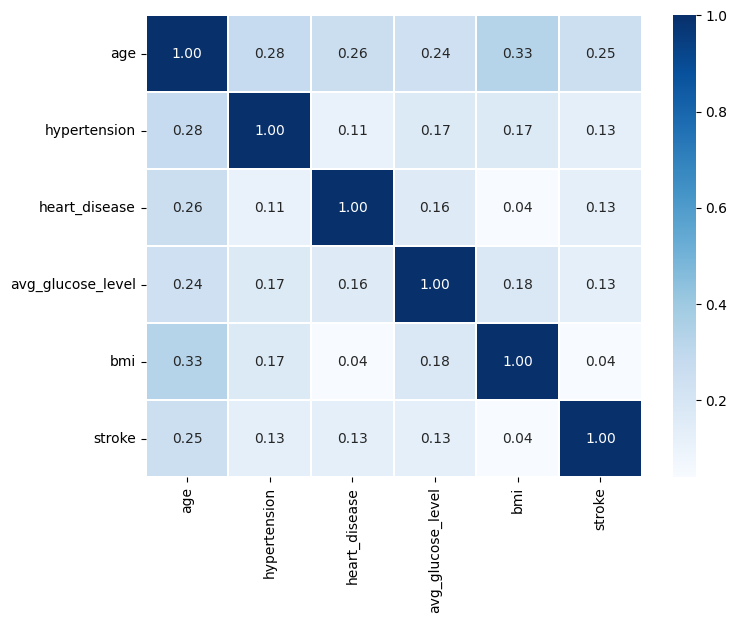

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt= '.2f',cmap= 'Blues',linewidths= 0.1)


In [10]:
df.stroke.unique()# CHECKING TARGET VARIABLE

array([1, 0], dtype=int64)

In [11]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

AN IMBALANCED DATASET 

<Axes: xlabel='stroke', ylabel='count'>

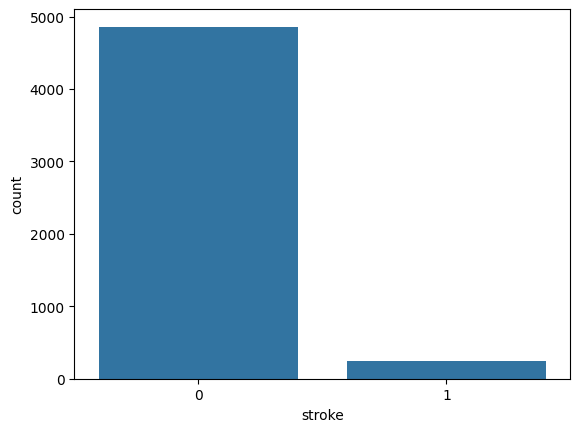

In [12]:
sns.countplot(x = df.stroke)

(0.0, 1.0, 0.0, 1.0)

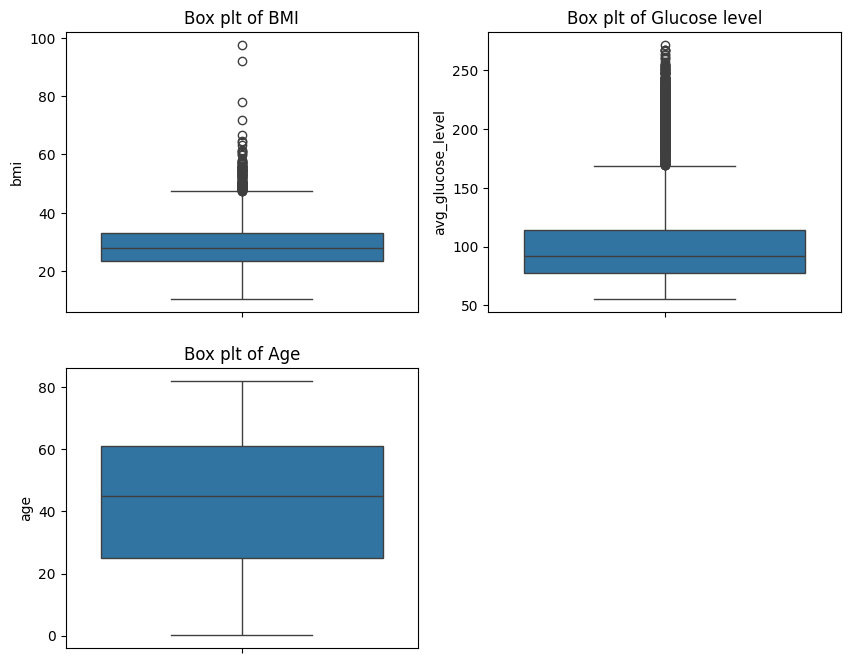

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.boxplot(y= df['bmi'], ax=ax1)
ax1.set_title('Box plt of BMI')
sns.boxplot(y= df['avg_glucose_level'], ax=ax2)
ax2.set_title('Box plt of Glucose level')
sns.boxplot(y=df['age'], ax=ax3)
ax3.set_title('Box plt of Age')

ax4.axis('off')

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

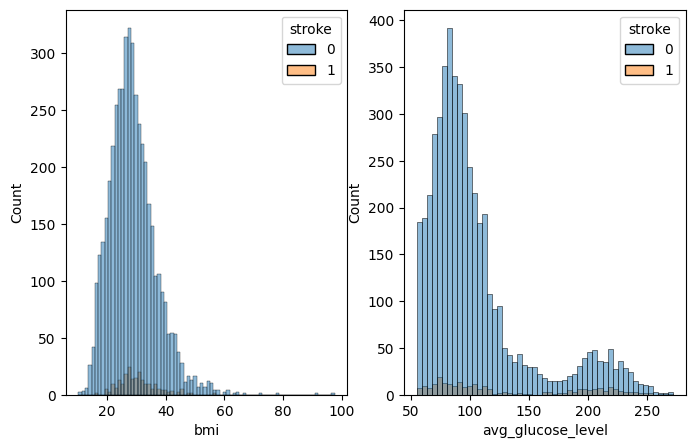

In [14]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
sns.histplot(x ='bmi', data= df,hue='stroke', ax=ax1)
sns.histplot(x= 'avg_glucose_level', hue='stroke', data= df, ax= ax2)


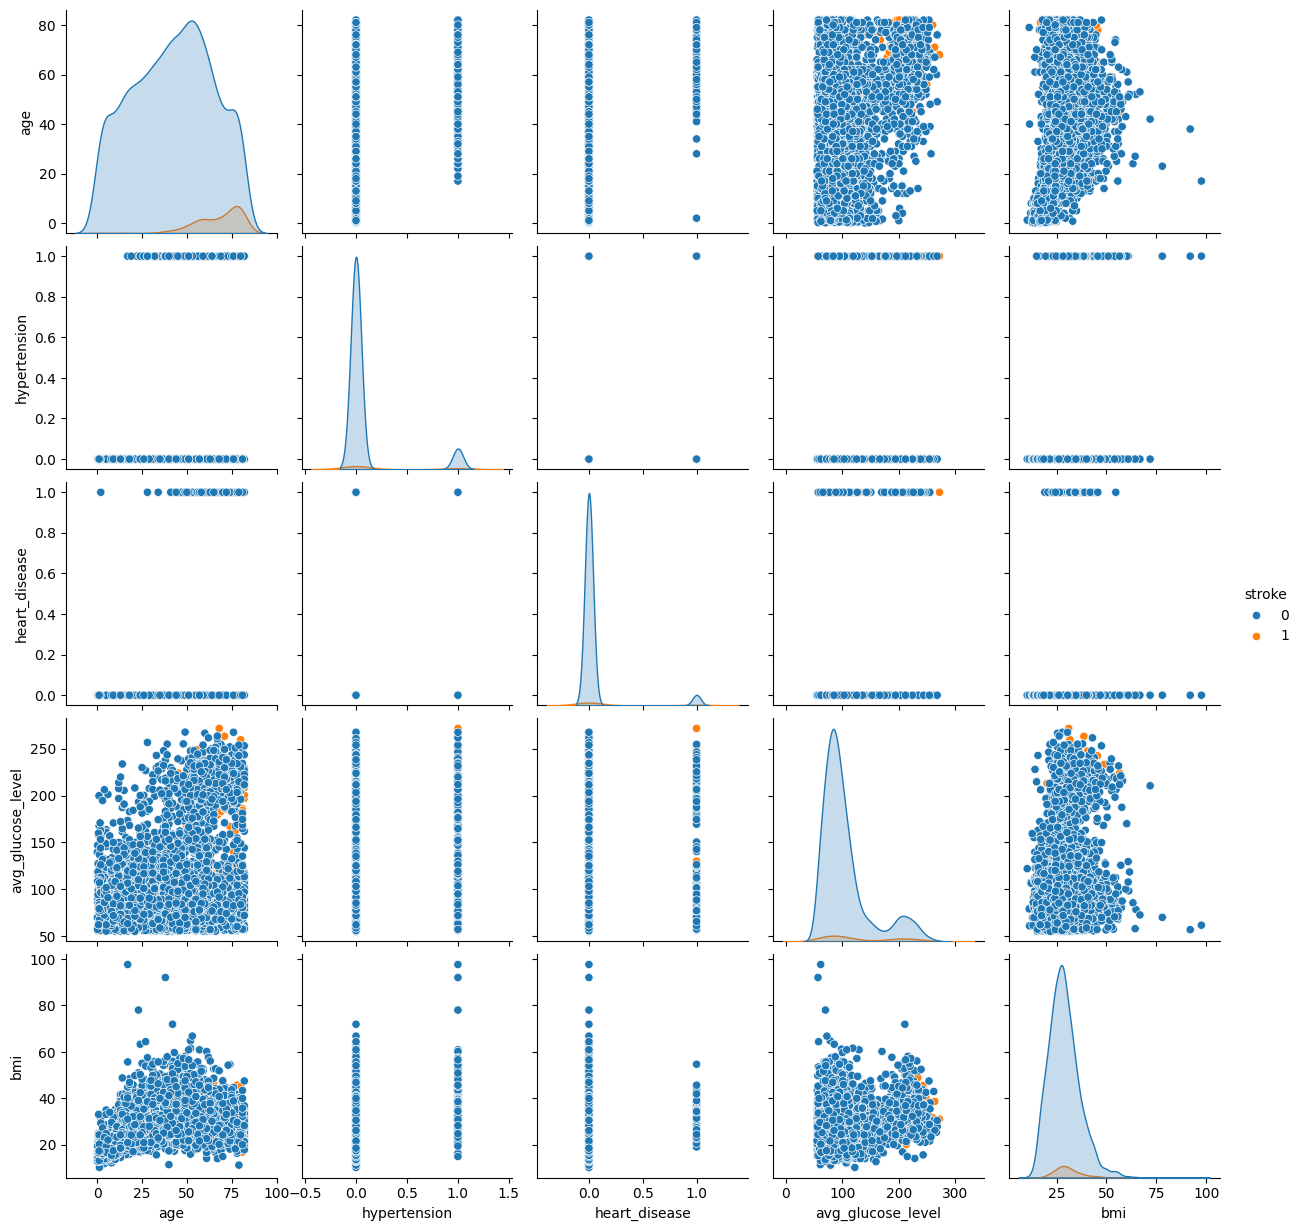

In [15]:
sns.pairplot(df[Numerical_columns], hue = 'stroke')

### CATEGORICAL FEATURES

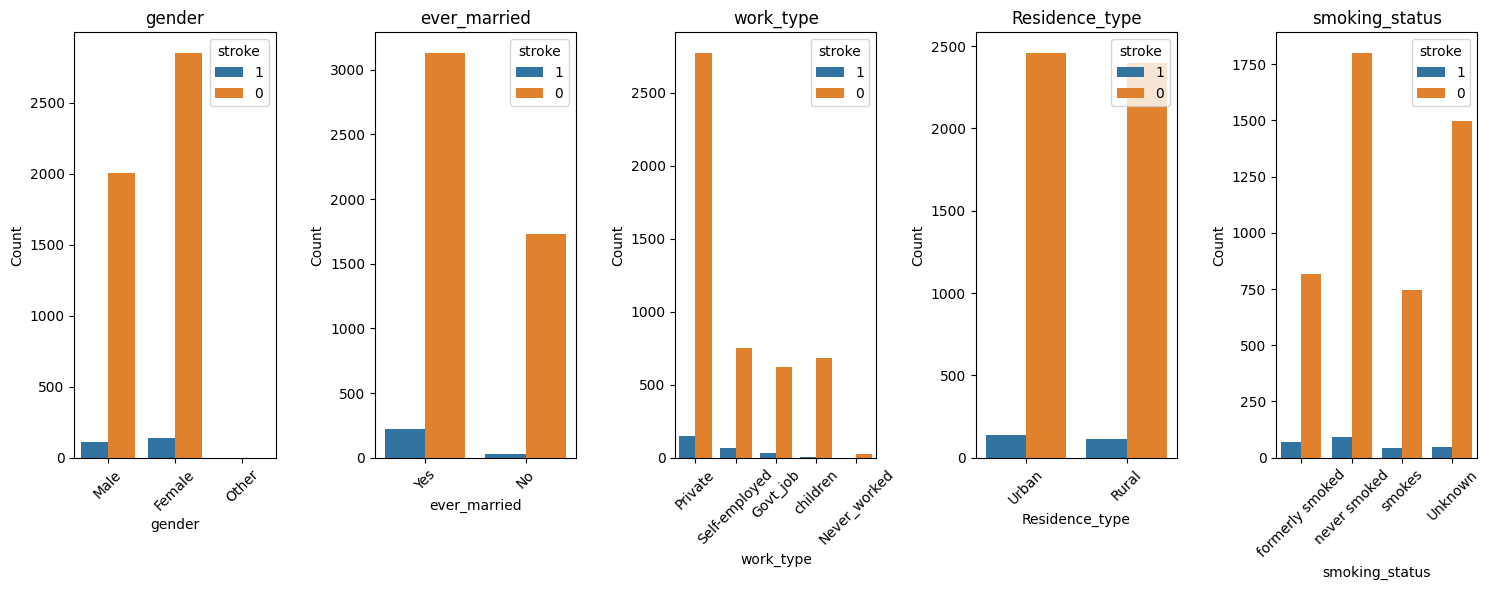

In [16]:
num_features = len(Categorical_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 6))

df['stroke'] = df['stroke'].astype(str)

for i, feature in enumerate(Categorical_columns):
    sns.countplot(x=df[feature], ax=axes[i], hue =df['stroke'])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

# **PREPROCESSING**

## Handling Missing/NA values


In [17]:
# Check for Missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We have 201 null values in the column bmi, so we need do imputation technique 

In [18]:
#IMPUTE MISSING VALUE WITH MEAN 
bmi_mean = df['bmi'].mean()
df.bmi = df['bmi'].fillna(bmi_mean)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


## Duplicates

In [19]:
# CHECK FOR DUPLICATE
df.duplicated().sum()

0

No duplicates found

## Handling Outliers

In [20]:
# Handling Outliers
numerical_columns_excluding_binary_age = [col for col in Numerical_columns if col not in ['hypertension', 'heart_disease', 'stroke', 'age']]
print(numerical_columns_excluding_binary_age)
Q1 = df[numerical_columns_excluding_binary_age].quantile(0.05)
Q3 = df[numerical_columns_excluding_binary_age].quantile(0.95)
print(Q1)
print(Q3)
IQR = Q3 - Q1
print(IQR)


['avg_glucose_level', 'bmi']
avg_glucose_level    60.7135
bmi                  17.7000
Name: 0.05, dtype: float64
avg_glucose_level    216.2945
bmi                   42.6550
Name: 0.95, dtype: float64
avg_glucose_level    155.581
bmi                   24.955
dtype: float64


Removing Outlier will affect in the prediction because glucose and bmi value will vary patient and in real time case, glucose and bmi will have high value. 

In [21]:
# df = df[~((df[numerical_columns_excluding_binary_age] < (Q1 - 1.5 * IQR)) |(df[numerical_columns_excluding_binary_age] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


## Feature Engineering


In [22]:
# Define function to map BMI to categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

In [23]:
def age_category(df, bins, labels):
    df['Age_category'] = pd.cut(df['age'], bins=bins, labels=labels).astype('object')
    return df

bins = [0, 20, 40, 60, 100]
labels = ['Young', 'Adult', 'Middle-aged', 'Senior']

df = age_category(df, bins, labels)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,Age_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Senior
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Overweight,Senior
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Obese,Senior
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Middle-aged
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal weight,Senior


In [24]:
new_features = df.columns
new_features 

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_category', 'Age_category'],
      dtype='object')

In [25]:
df.stroke.dtypes

dtype('O')

In [26]:
df['stroke']=df['stroke'].astype(int)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,Age_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Senior
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Overweight,Senior
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Obese,Senior
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Middle-aged
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal weight,Senior


<Axes: xlabel='bmi_category', ylabel='percent'>

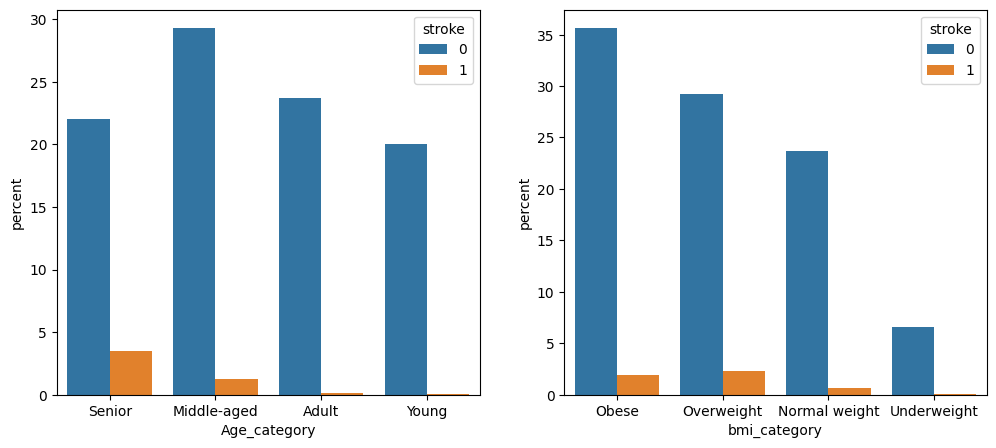

In [27]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot( x = df['Age_category'], hue = df['stroke'], ax = ax1, stat = 'percent')
sns.countplot( x = df['bmi_category'], hue = df['stroke'], ax = ax2, stat = 'percent')


In [28]:
df.Age_category.dtype

dtype('O')

In [29]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,Age_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Senior
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Overweight,Senior
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Obese,Senior
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Middle-aged
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal weight,Senior


## Feature Encoding

In [30]:
#Label Encoding 
Categorical_column = [feature for feature in new_features if df[feature].dtype =='O']
def label_encode_categorical(df, categorical_columns):
     encoding = LabelEncoder()
     for column in Categorical_column:
          df[column] = encoding.fit_transform(df[column])
     return df

In [31]:
encoded_df = label_encode_categorical(df, Categorical_columns)
encoded_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,Age_category
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,1,2
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1,2,2
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,1,2
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,1,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,0,2


In [32]:
# Add the 'stroke' column to the end
stroke_column = encoded_df.pop('stroke')
encoded_df['stroke'] = stroke_column


In [33]:
encoded_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_category,Age_category,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,2,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,2,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,1,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,0,2,1


In [34]:
encoded_df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_category,Age_category,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,0.414286,43.226614,0.097456,0.054012,0.656164,2.167710,0.508023,106.147677,28.893237,1.376908,1.203718,1.417808,0.048728
std,0.493044,22.612647,0.296607,0.226063,0.475034,1.090293,0.499985,45.283560,7.698018,1.071534,0.883609,1.059123,0.215320
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,2.000000,0.000000,77.245000,23.800000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,2.000000,1.000000,91.885000,28.400000,2.000000,1.000000,1.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,3.000000,1.000000,114.090000,32.800000,2.000000,2.000000,2.000000,0.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,3.000000,3.000000,1.000000


## Splitting Data Dependent and Independent Variables

In [35]:
#Independent and dependent columns
X = encoded_df.drop(columns='stroke')
y = encoded_df['stroke']

## Handling Imbalance Data

In [36]:
# TO OVERCOME IMBALANCED DATASET
from imblearn.over_sampling import SMOTE

smote= SMOTE()
x1,y1 =smote.fit_resample(X,y)
print(x1.shape)
print(y1.shape)
y1.value_counts()
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y1)))

(9722, 12)
(9722,)
The number of classes before fit Counter({0: 4861, 1: 249})
The number of classes after fit Counter({1: 4861, 0: 4861})


## Normalization

In [37]:
numeric_columns = ['age', 'avg_glucose_level', 'bmi']
standard_scaler =StandardScaler()
x1[numeric_columns] = standard_scaler.fit_transform(x1[numeric_columns])

# **MODEL BUILDING**

In [38]:
#Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(x1,y1,train_size=0.8, random_state=42, stratify=y1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(7777, 12)
(1945, 12)
(7777,)
(1945,)


In [39]:
#logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train,y_train)
y_pred =log_reg_model.predict(X_test)
log_accuracy = accuracy_score(y_pred, y_test)
print(log_accuracy)

0.8123393316195373


In [40]:

log_grid = GridSearchCV(estimator = log_reg_model,param_grid = {'penalty': ['l2'],
                                                     'tol':[0.1,1e-2, 1e-4,1e-6],
                                                     'C': [float(x) for x in np.linspace(1,10,10)],
                                                     'fit_intercept':[True,False]
    
}, cv=3, n_jobs=-1, verbose=2 )
log_grid.fit(X_train,y_train)



Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                               10.0],
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'tol': [0.1, 0.01, 0.0001, 1e-06]},
             verbose=2)

In [103]:
print(log_grid.best_params_)
print(log_grid.best_estimator_)
log_best_grid_cv = log_grid.best_estimator_
y_pred = log_best_grid_cv.predict(X_test)
Accuracy_1 = accuracy_score(y_pred, y_test)
print(f'Accuracy:',Accuracy_1)
print('\n')
print(f'Classification Report :', '\n',classification_report(y_pred, y_test))
print(f'Confusion Matrix :','\n',confusion_matrix(y_pred, y_test))

{'C': 2.0, 'fit_intercept': True, 'penalty': 'l2', 'tol': 0.1}
LogisticRegression(C=2.0, tol=0.1)
Accuracy: 0.8123393316195373


Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       932
           1       0.83      0.80      0.82      1013

    accuracy                           0.81      1945
   macro avg       0.81      0.81      0.81      1945
weighted avg       0.81      0.81      0.81      1945

Confusion Matrix : 
 [[770 162]
 [203 810]]


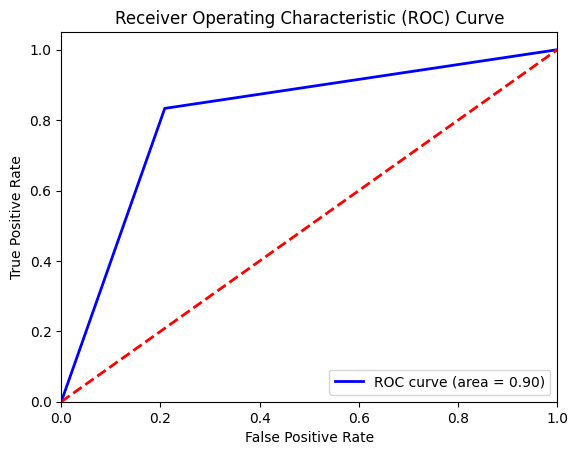

In [108]:
roc_auc= roc_auc_score(y_test, log_best_grid_cv.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [111]:
#SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train,y_train)
y_pred =svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_pred, y_test)
print(svm_accuracy)

0.8694087403598971


In [118]:

svm_grid = GridSearchCV(estimator = svm_model,param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                                     'tol':[0.1,1e-2, 1e-4,1e-6],
                                                     'C': [float(x) for x in np.linspace(1,20,10)]
                                                     
    
}, cv=3, n_jobs=-1, verbose=2 )
svm_grid.fit(X_train,y_train)



Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1.0, 3.111111111111111, 5.222222222222222,
                               7.333333333333334, 9.444444444444445,
                               11.555555555555555, 13.666666666666668,
                               15.777777777777779, 17.88888888888889, 20.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.1, 0.01, 0.0001, 1e-06]},
             verbose=2)

In [119]:
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)
svm_best_grid_cv = svm_grid.best_estimator_
y_pred = svm_best_grid_cv.predict(X_test)
Accuracy_2 = accuracy_score(y_pred, y_test)
print(f'Accuracy:',Accuracy_2)
print('\n')
print(f'Classification Report :', '\n',classification_report(y_pred, y_test))
print(f'Confusion Matrix :','\n',confusion_matrix(y_pred, y_test))

{'C': 20.0, 'kernel': 'rbf', 'tol': 0.01}
SVC(C=20.0, probability=True, tol=0.01)
Accuracy: 0.8874035989717224


Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       880
           1       0.94      0.85      0.89      1065

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0.89      1945
weighted avg       0.89      0.89      0.89      1945

Confusion Matrix : 
 [[817  63]
 [156 909]]


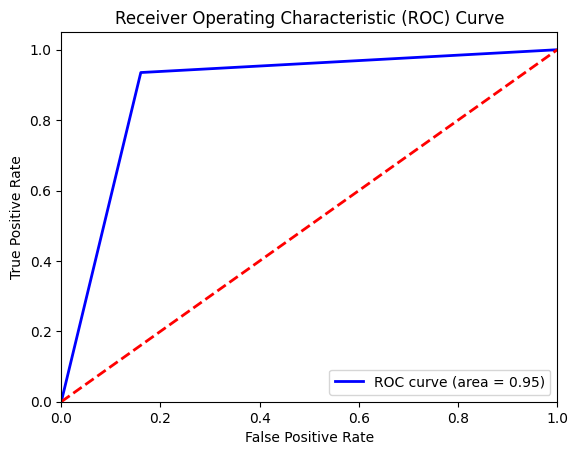

In [120]:
roc_auc= roc_auc_score(y_test,svm_best_grid_cv.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
#Random forest
rf_model =RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred= rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_pred, y_test)
print(rf_accuracy)

0.9465295629820052


In [46]:

rf_random = RandomizedSearchCV(estimator = rf_model,param_distributions={'n_estimators':[int(x)for x in np.linspace(start=100,stop=1000,num=10)],
                                                                         'criterion':['gini', 'entropy', 'log_loss'],
                                                                         'max_depth':[int(x)for x in np.linspace(10,1000,10)],
                                                                         'min_samples_split':[2,4,6,8,10],
                                                                         'min_samples_leaf':[1,2,3,4,6,8],
                                                                         'max_features': ['sqrt', 'log2'],
                                                                         'ccp_alpha': [0.1,1e-2, 1e-4,1e-6],
                                                                         'bootstrap':[True,False]
    
},n_iter=100,n_jobs=-1,verbose =2,random_state=100, cv=3)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.1, 0.01, 0.0001, 1e-06],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=100, verbose=2)

In [88]:
print(rf_random.best_params_)
print(rf_random.best_estimator_)
rf_best_random_cv = rf_random.best_estimator_
y_pred = rf_best_random_cv.predict(X_test)
print(f'Accuracy:',accuracy_score(y_pred, y_test))
print('\n')
print(f'Classification Report :', '\n',classification_report(y_pred, y_test))
print(f'Confusion Matrix :','\n',confusion_matrix(y_pred, y_test))

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 670, 'criterion': 'entropy', 'ccp_alpha': 1e-06, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, ccp_alpha=1e-06, criterion='entropy',
                       max_depth=670, n_estimators=800)
Accuracy: 0.9598971722365038


Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       957
           1       0.97      0.95      0.96       988

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

Confusion Matrix : 
 [[926  31]
 [ 47 941]]


In [48]:
rf_Grid = GridSearchCV(estimator =rf_model,param_grid={'ccp_alpha':[rf_random.best_params_['ccp_alpha']],
                                                'n_estimators': [rf_random.best_params_['n_estimators']-200, rf_random.best_params_['n_estimators']-100,rf_random.best_params_['n_estimators'],
                                                                rf_random.best_params_['n_estimators']+100, rf_random.best_params_['n_estimators']+200 ],
                                                'bootstrap':[rf_random.best_params_['bootstrap']],
                                                'max_features':[rf_random.best_params_['max_features']],
                                                'min_samples_leaf':[rf_random.best_params_['min_samples_leaf'],rf_random.best_params_['min_samples_leaf']+1],
                                                'min_samples_split':[rf_random.best_params_['min_samples_split'],
                                                                    rf_random.best_params_['min_samples_split']+1, rf_random.best_params_['min_samples_split']+2],
                                                'max_depth': [rf_random.best_params_['max_depth']],
                                                'criterion':[rf_random.best_params_['criterion']]
                  
    
},cv=10,n_jobs=-1, verbose =2)
print(rf_Grid)
rf_Grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'ccp_alpha': [1e-06],
                         'criterion': ['entropy'], 'max_depth': [670],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [600, 700, 800, 900, 1000]},
             verbose=2)
Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'ccp_alpha': [1e-06],
                         'criterion': ['entropy'], 'max_depth': [670],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [600, 700, 800, 900, 1000]},
             verbose=2)

In [99]:
print(rf_Grid.best_params_)
print(rf_Grid.best_estimator_)
rf_best_grid_cv = rf_Grid.best_estimator_
y_pred = rf_best_grid_cv.predict(X_test)
Accuracy_3 = accuracy_score(y_pred, y_test)
print(f'Accuracy:',Accuracy_3)
print('\n')
print(f'Classification Report :', '\n',classification_report(y_pred, y_test))
print(f'Confusion Matrix :','\n',confusion_matrix(y_pred, y_test))

{'bootstrap': False, 'ccp_alpha': 1e-06, 'criterion': 'entropy', 'max_depth': 670, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=False, ccp_alpha=1e-06, criterion='entropy',
                       max_depth=670, min_samples_split=3, n_estimators=1000)
Accuracy: 0.9598971722365038


Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       957
           1       0.97      0.95      0.96       988

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

Confusion Matrix : 
 [[926  31]
 [ 47 941]]


In [50]:
#Finally using best parameters that got from previous searching
random_forest =RandomForestClassifier(bootstrap=False, ccp_alpha=1e-06, criterion='entropy',
                       max_depth=670, n_estimators=900, max_features= 'sqrt')
random_forest.fit(X_train,y_train)



RandomForestClassifier(bootstrap=False, ccp_alpha=1e-06, criterion='entropy',
                       max_depth=670, n_estimators=900)

In [116]:
y_pred = random_forest.predict(X_test)
print(f'Accuracy:',accuracy_score(y_pred, y_test))
print('\n')
print(f'Classification Report :', '\n',classification_report(y_pred, y_test))
print(f'Confusion Matrix :','\n',confusion_matrix(y_pred, y_test))

Accuracy: 0.9593830334190231


Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       950
           1       0.97      0.95      0.96       995

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

Confusion Matrix : 
 [[922  28]
 [ 51 944]]


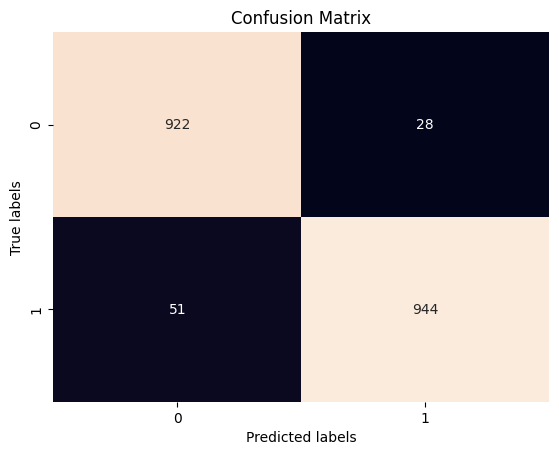

In [52]:
cm=confusion_matrix(y_pred, y_test) 
sns.heatmap(cm,annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

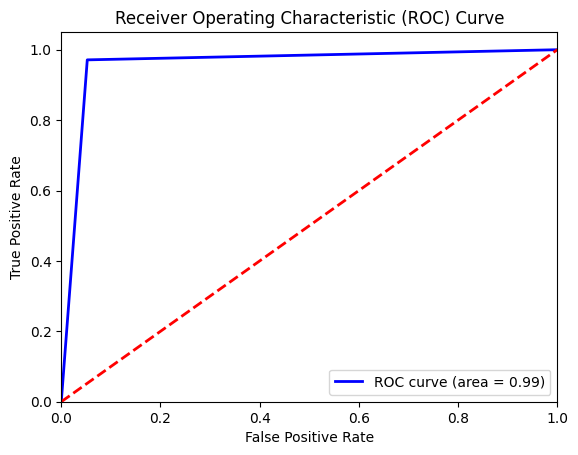

In [117]:
roc_auc= roc_auc_score(y_test,random_forest.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

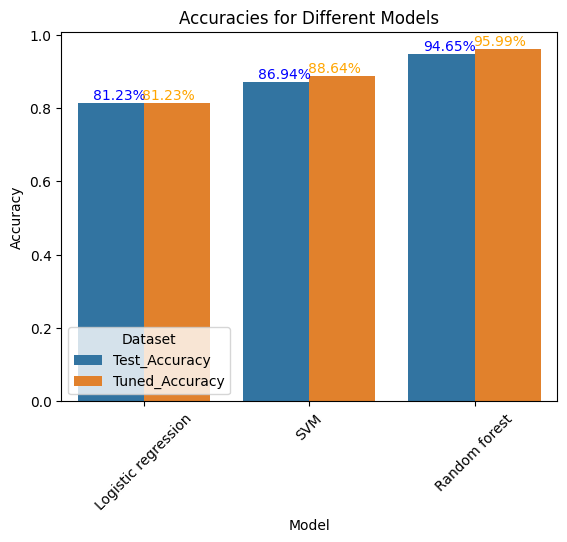

In [105]:
# Overall model interpretation in bar graph

models = ['Logistic regression', 'SVM', 'Random forest']
test_accuracies = [log_accuracy, svm_accuracy, rf_accuracy]
test_accuracies_tuning = [Accuracy_1, Accuracy_2, Accuracy_3]

df = pd.DataFrame({'Model': models * 2,
                   'Accuracy': test_accuracies + test_accuracies_tuning,
                   'Type': ['Test_Accuracy'] * len(models) + ['Tuned_Accuracy'] * len(models)})


sns.barplot(data=df, x='Model', y='Accuracy', hue='Type')
for i in range(len(models)):
    plt.text(i - 0.15, test_accuracies[i] + 0.01, f"{test_accuracies[i]*100:.2f}%", ha='center', color='blue')
    plt.text(i + 0.15, test_accuracies_tuning[i] + 0.01, f"{test_accuracies_tuning[i]*100:.2f}%", ha='center', color='orange')
    
plt.legend(title='Dataset', loc='lower left')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracies for Different Models')
plt.show()

In [54]:
with open('rf_model_pickle.pkl','wb') as file:
    pickle.dump(random_forest,file)
